DATASET

Cityscapes data (dataset home page) contains labeled videos taken from vehicles driven in Germany. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. 

Content
This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.

Importing the required libraries

Importing the required libraries
First of all I imported the required libraries (The list kept increasing as I moved along to solve the problem). THe most important one's are described below:-

Numpy - for linear algebra
os - for receiving information about files
matplotlib - for visualizing
PIL and CV2 - for image loading and editing
scikit-learn KMeans - for color clustering
random - for generating random numbers and choices
keras - a high level interface to tensorflow (for neural networks)

In [1]:
import os
import matplotlib.pyplot as plot
from PIL import Image
#import cv2
from sklearn.cluster import KMeans
import random


In [11]:
# import sys
# !{sys.executable} -m pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=c047993e71cd5802af58a49c2eadb69619cd71a10d8df5c82cef03a73c83c834
  Stored in directory: c:\users\tusha\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor


In [2]:
import cv2
import numpy as np

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D, concatenate
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

In [19]:
# import sys
# !{sys.executable} -m pip install cv2module

  Using cached cv2module-0.1.2-py3-none-any.whl (6.7 kB)


After some searching all required libraries are now successfully installed

Using LoadImage finction to split raw and segmented image

The images are side-by-side images of the raw image and a color coded segmented image. The function splits the image into seperate images and cuts the engine hood away.

LoadImage - Loads a single image and its corresponding segmentation map
Arguements :
name - Name of the image file
path - Path to the image directory
Returns - A tuple of 2 numpy arrays (image and segmentation map)

Train data consists of 2805 images at this point 
Test data consists of 408 images

In [3]:
#https://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html


def LoadImage(name, path=r"C:\Users\tusha\Project- Image segmentation\data\train",
             rotation=0.0, flip=False, cut_bottom=58,
             size=(256, 200)):
    img = Image.open(path+"/"+name)
    img = np.array(img)
    seg = img[:-cut_bottom, 256:]
    img = img[:-cut_bottom, 0:256]
    
    for i in range(3):
        zimg = img[:,:,i]
        zimg = cv2.equalizeHist(zimg)
        img[:,:,i] = zimg
    
    img = Image.fromarray(img).resize(size)
    seg = Image.fromarray(seg).resize(size)
    
    

    img = img.rotate(rotation)
    seg = seg.rotate(rotation)

    img = np.array(img)
    seg = np.array(seg)

    if flip:
        img = img[:,::-1,:]
        
        seg = seg[:,::-1,:]

            
    return img/255, seg/255

Reference: https://www.geeksforgeeks.org/extract-dominant-colors-of-an-image-using-python/
Refer to test copy for examples

Color clustering
Due to the compression of the JPEG standard, there are more than only a few discrete colors in the segmented image. To find the most imortant colors and identify similar colors we can use KMeans clustering. This also allows us to go from a color representation to a class representation.

For reference check the file: parameter selection tests in the same folder 

In [4]:
files =os.listdir(r"C:\Users\tusha\Project- Image segmentation\data\train")[0:10] 

colors = []
for file in files:
    img, seg = LoadImage(file)
    colors.append(seg.reshape(seg.shape[0]*seg.shape[1], 3))
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))

km = KMeans(13)
km.fit(colors)

KMeans(n_clusters=13)

In [5]:
colors

array([[0.        , 0.        , 0.00784314],
       [0.0627451 , 0.07843137, 0.09019608],
       [0.        , 0.00392157, 0.02745098],
       ...,
       [0.88627451, 0.17254902, 0.83921569],
       [0.85490196, 0.23921569, 0.83921569],
       [0.53333333, 0.        , 0.54117647]])

Layers to RGB Image
After clustering the image contains information about 13 different layers. Computer displays can only utilize the RGB colorspace. This function converts the layer representation to a color representation. This is just for visualizing.

Example: 

def getSegmentationArr(image, classes, width=width, height=height):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

   for c in range(classes):
      seg_labels[:, :, c] = (img == c ).astype(int)
   return seg_labels

In [6]:

def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg

Colors to Class
This function converts the discrete color representation (output of the color clustering) to a 13-dimensional class representation. This is useful for the machine learning algorithm later on. On the bottom you can see an example classification layed over the raw image.

Example: 

Categorical Arrays to Colored Segmentation Masks
def give_color_to_seg_img(seg, n_classes=13):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

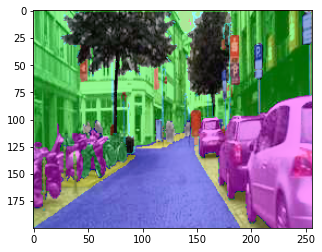

In [7]:
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(km.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

img, seg = LoadImage("90.jpg")
seg2 = ColorsToClass(seg)
seg2 = LayersToRGBImage(seg2)
total = cv2.addWeighted(img, 0.6, seg2, 0.4, 0)
plot.imshow(total[:,:,:])
plot.show()

The Data Generator
To make training more memory efficient a generator is used for feeding the data to the deep learning algorithm. This generator creates batches of e.g. 10 raw-segmented image pairs at a time. It also uses image augmentation and randomly flips and rotates the images to increase the effective size of the dataset.
At the bottom you can see one such pair.

DataGenerator - Returns data in form of batches
Arguements :
path - location or path of the image directory
batch_size - size of each batch
Example: 

def DataGenerator(path, batch_size=10, classes=13):
    files = os.listdir(path)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i : i+batch_size]
            imgs=[]
            segs=[]



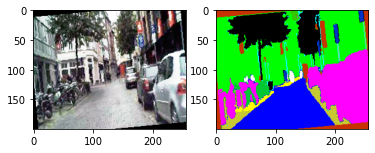

In [8]:
def Generate(path= r"C:\Users\tusha\Project- Image segmentation\data\train", batch_size=10,
            maxangle=10.0):
    
    files = os.listdir(path)
    while True:
        imgs=[]
        segs=[]
        
        for i in range(batch_size):
            file = random.sample(files,1)[0]
            
            flip=False
            if random.random() > 0.5:
                flip=True
            
            angle = maxangle*(random.random()*2-1)
            
            img, seg = LoadImage(file, path, rotation=angle, flip=flip)
            
            seg = ColorsToClass(seg)
            
            imgs.append(img)
            segs.append(seg)
        yield np.array(imgs), np.array(segs)
        
gen = Generate()
imgs, segs = next(gen)

plot.subplot(121)
plot.imshow(imgs[0])
plot.subplot(122)
plot.imshow(LayersToRGBImage(segs[0]))
plot.show()

The Intuition Behind UNet
The main idea behind CNN is to learn the feature mapping of an image and exploit it to make more nuanced feature mapping. This works well in classification problems as the image is converted into a vector which used further for classification. But in image segmentation, we not only need to convert feature map into a vector but also reconstruct an image from this vector. This is a mammoth task because it’s a lot tougher to convert a vector into an image than vice versa. The whole idea of UNet is revolved around this problem.
CNN : Convolutional Neural Networks
The contraction, The bottleneck, and the expansion section.


https://towardsdatascience.com/u-net-b229b32b4a71
https://tuatini.me/practical-image-segmentation-with-unet/
             
https://medium.com/@SmartLabAI/deep-learning-based-semantic-segmentation-in-simulation-and-real-world-for-autonomous-vehicles-e7fe25cef816

https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5
             
            

In [9]:
inp = Input(shape=(200, 256, 3))

x1 = BatchNormalization()(inp)
x1 = Conv2D(64, 12, activation="relu", padding="same")(x1)
x1 = Conv2D(128, 12, activation="relu", padding="same")(x1)
p1 = MaxPooling2D()(x1)
#p1 = Dropout(0.2)(p1)

#x2 = BatchNormalization()(x1)
x2 = Conv2D(128, 9, activation="relu", padding="same")(p1)
x2 = Conv2D(128, 9, activation="relu", padding="same")(x2)
p2 = MaxPooling2D()(x2)
#p2 = Dropout(0.2)(p2)

#x3 = BatchNormalization()(x2)
x3 = Conv2D(128, 6, activation="relu", padding="same")(p2)
x3 = Conv2D(128, 6, activation="relu", padding="same")(x3)
p3 = MaxPooling2D()(x3)
#p3 = Dropout(0.2)(p3)

#x4 = BatchNormalization()(x3)
x4 = Conv2D(128, 3, activation="relu", padding="same")(p3)
x4 = Conv2D(128, 3, activation="relu", padding="same")(x4)
#x4 = MaxPooling2D()(x4)
#x4 = Dropout(0.2)(x4)

x5 = UpSampling2D()(x4)
x5 = concatenate([x3, x5])
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
#x5 = Dropout(0.2)(x5)

x6 = UpSampling2D()(x5)
x6 = concatenate([x2, x6])
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
#x6 = Dropout(0.2)(x6)

x7 = UpSampling2D()(x6)
x7 = concatenate([x1, x7])
x7 = Conv2D(13, 6, activation="relu", padding="same")(x7)
x7 = Conv2D(13, 6, activation="softmax", padding="same")(x7)



model = Model(inp, x7)

opt = Adam(lr=0.0001)
model.compile(optimizer=opt,
             loss="categorical_crossentropy",
             metrics=["accuracy"])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 256, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 256, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 256, 64) 27712       batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 256, 128 1179776     conv2d[0][0]                     
_______________________________________________________________________________________

The network has 9 million trainable parameters.

The next step is to create two generators:

Training generator - for training data
Validation generator - to prevent overfitting

In [10]:
train_gen = Generate()
val_gen = Generate(r"C:\Users\tusha\Project- Image segmentation\data\val")

Training
Finally start training. We will train for 1000, (changed to 10 later for testing) epochs and use a Model Checkpoint to save the model with the smalles validation loss.

Currently the epoch value is set at 2 for testing . Increasing the number to higher values will lead to more accuracy and the reduction of loss.



In [ ]:

clb = [ModelCheckpoint("loss.h5", save_best_only=True, verbose=0)]

h = model.fit_generator(train_gen, epochs=2, steps_per_epoch=10,
                       validation_data=val_gen, validation_steps=10,
                       callbacks=clb, verbose=0)

Instructions for updating:
Please use Model.fit, which supports generators.


Saving the model and loading the best model from the training run.

In [12]:
model.save("model.h5")
model = load_model("loss.h5")

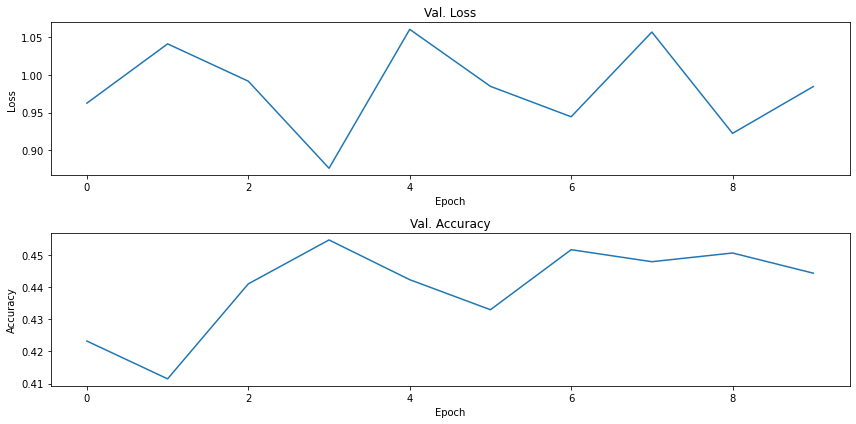

In [38]:
loss = h.history["val_loss"]
acc = h.history["val_accuracy"]

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Val. Loss")
plot.plot(loss)
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Val. Accuracy")
plot.plot(acc)
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
plot.savefig("learn.png", dpi=150)
plot.show()

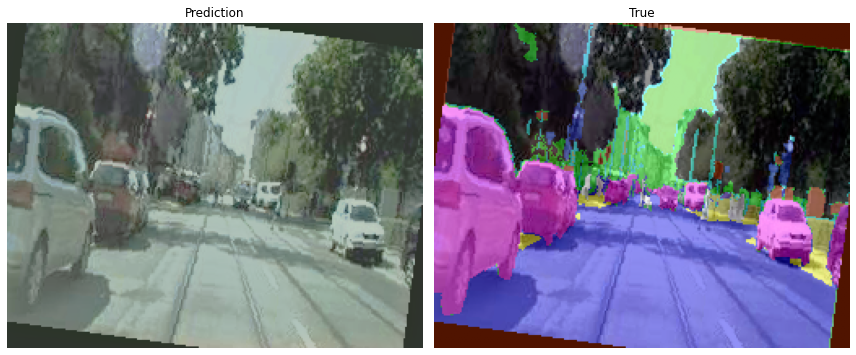

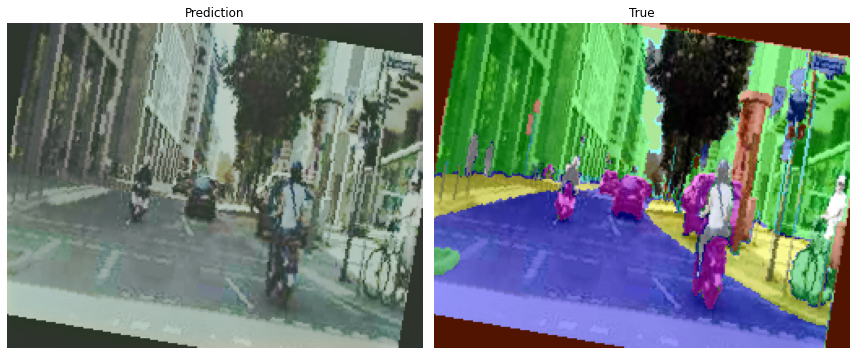

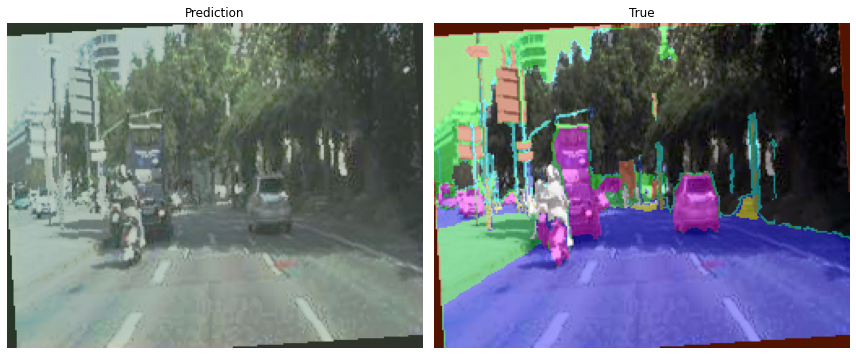

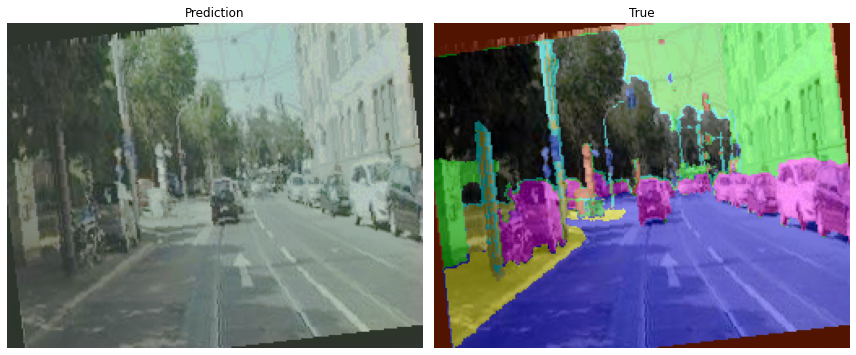

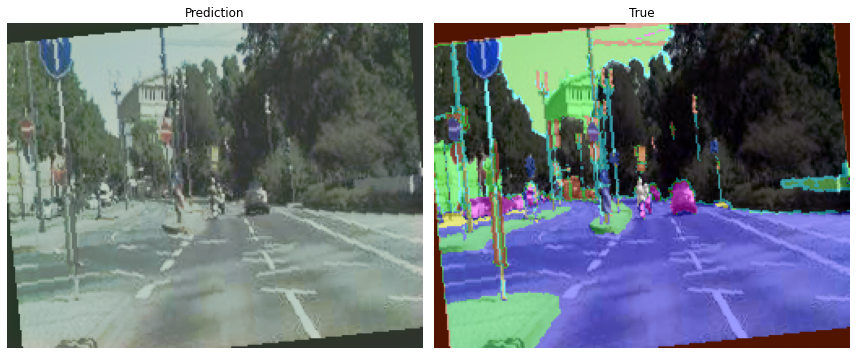

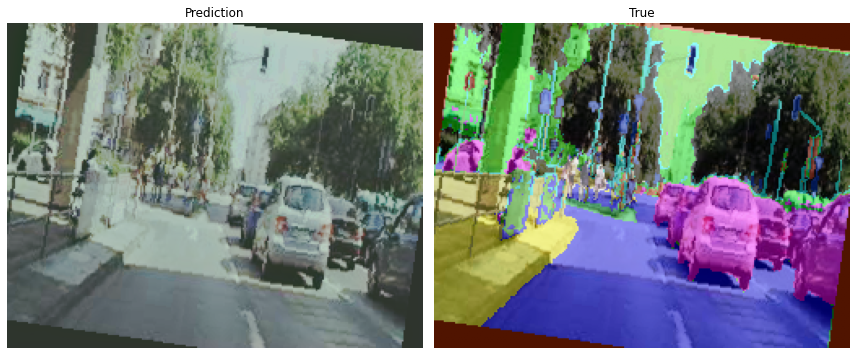

In [13]:
test_gen = Generate(r"C:\Users\tusha\Project- Image segmentation\data\val")
max_show=5
for imgs, segs in test_gen:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        
        predimg = cv2.addWeighted(imgs[i], 0.6, _p, 0.4, 0)
        trueimg = cv2.addWeighted(imgs[i], 0.6, _s, 0.4, 0)
        plot.figure(figsize=(12,6))
        plot.subplot(121)
        plot.title("Prediction")
        plot.imshow(predimg)
        plot.axis("off")
        plot.subplot(122)
        plot.title("True")
        plot.imshow(trueimg)
        plot.axis("off")
        plot.tight_layout()
        plot.savefig("pred_"+str(i)+".png", dpi=150)
        plot.show()
    break